# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

Necessary packages are imported here.

In [1]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from math import ceil
from prettytable import PrettyTable

I perform some initial set-up of the environment.

In [2]:
# Visualizations will be shown in the notebook.
get_ipython().magic('matplotlib inline')
%matplotlib inline

# Set Tensorflow configuration options
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Set to True to prevent TF from pre-allocating all available GPU memory

evaluate_test_set = True  # Set to True to evaluate the model against the test set after training

Functions useful for dataset and computation visualization are defined below.

In [3]:
def plot_images(images, cls_true, cls_pred=None):
    """
    Plots at most nine images arranged in a 3x3 grid, each with a caption of its correct class and, optionally, of its
    predicted class.
    Adapted from: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
    """
    assert len(images) == len(cls_true) <= 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        if i >= len(images):
            continue
        # Plot image.
        ax.imshow(images[i])

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)


def plot_labels_histogram(labels):
    """
    Plots a histogram of frequencies of all the items in the list-like parameter `labels`,
    which is assumed to be a list of lists.
    Will be used to display the relative frequency of different classes in datasets
    """
    # Count the number of different labels
    n_labels = len(set(labels[0]))
    fig, ax = plt.subplots()
    fig.set_dpi(108)
    fig.set_figheight(8)
    ax.hist(labels, bins=n_labels, rwidth=.9, align='mid', range=(-.5, n_labels - .5), normed=True,
            orientation='horizontal', label=['Training','Validation','Test'])
    ax.set_title('Frequency of different classes in datasets')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    
def plot_probabilities(probabilities, images, cls_true=None, cls_pred=None):
    """
    Plots the images in a column, and next to each a bar chart of its softmax probabilities
    :param probabilities: a list of lists, item [img][i_class] is the probability assigned to image `images[img]` to belong to class `i_class`.
    :param images: the list of images
    """
    from matplotlib.ticker import MultipleLocator
    assert len(probabilities) == len(images)
    fig, axes = plt.subplots(len(probabilities), 2, gridspec_kw={'width_ratios': [1, 4], 'hspace': .6, 'wspace': .5})
    fig.set_dpi(108)
    fig.set_figheight(len(images))
    for idx, X in enumerate(images):
        axes[idx, 0].imshow(X)
        axes[idx, 0].set_xticks([])
        axes[idx, 0].set_yticks([])
        minorLocator = MultipleLocator(1)
        axes[idx, 1].xaxis.set_minor_locator(minorLocator)
        axes[idx, 1].set_xlim([0-.5,len(probabilities[idx])-.5])
        axes[idx, 1].bar(range(len(probabilities[idx])), probabilities[idx])
        if cls_true is None and cls_pred is None:
            continue
        label=''
        if cls_true is not None:
            label+='True: {0}'.format(cls_true[idx])
            if cls_pred is not None:
                label+=', '
        if cls_pred is not None:
            label+='Pred: {0}'.format(cls_pred[idx])
        if label != '':
            axes[idx, 0].set_xlabel(label)

            
def show_image(image):
    """
    Plots the image
    """
    fig, ax = plt.subplots()
    ax.imshow(X_add_orig[3])
    ax.set_xticks([])
    ax.set_yticks([])

Functions useful to pre-process datasets before feeding them to the neural network. Pre-processing of datasets improves classification accuracy.

In [4]:
def expand_dynamic_range(image):
    """
    Maximizes the range of values for each channel in the given `image`, and returns the result.
    Scales the pixel values of the image (on a per-channel basis) such that, in every
    channel, pixels with the lowest value will have value 0, and pixels with the highest
    value will have value 255
    """
    lower, upper = float(np.min(image)), float(np.max(image))
    image = np.array((image - lower) / (upper - lower) * 255.5, dtype='uint8')
    assert np.min(image) == 0 and np.max(image) == 255
    return image


def normalize_with_averages(X, averages):
    '''
    Normalizes the dataset by mapping image pixels from interval [0, 255] to interval (of real numbers) [-1. 1.],
    then subtracting from each pixel the given `averages` on a per-channel basis. Returns the normalized dataset.
    '''
    X = (X / 255 - .5) * 2 - averages
    return X


def normalize(X):
    '''
    Normalizes the dataset by mapping image pixels from interval [0, 255] to interval (of real numbers) [-1. 1.],
    then subtracting from each pixel the average across the training set, on a per-channel basis. Returns the
    normalized dataset, and an array with per-channel averages before normalization
    '''
    X = (X / 255 - .5) * 2
    averages = np.average(X, axis=(0, 1, 2))
    X = X - averages
    return X, averages


def pre_process_dataset(X, averages=None):
    '''
    Converts images in the dataset from RGB to YUV, and discards the U and V channels; then expands the dynamic
    range of each image to the [0, 255] interval, and then normalizes every image to be in
    the range [-1, 1] and subtracts the given averages from it. If no averages are passed,
    then it computes and uses the averages of the dataset. Returns the resulting dataset,
    with shape [?, 32, 32, 1], and the averages used for normalization. 
    '''
    X = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2YUV) for image in X])
    X = X[:, :, :, 0:1]
    # Maximize the dynamic range individually for each image in the datase
    X = np.array([expand_dynamic_range(image) for image in X])
    if averages is None:
        # Normalize the training set
        X, averages = normalize(X)
    else:
        # Normalize also the validation and test set, but using the average per-channel of the training set
        X = normalize_with_averages(X, averages)
    return X, averages

Functions below are used to build the neural network, as a Tensorflow graph: they define the network architecture.

In [5]:
def get_conv_layer(input_layer, filter_size, filters_number, name=None):
    """
    Returns a convolutional layer to slide `filters_number` square filters with side `filter_size` across
    the `input_layer`, with the given name.
    Weights are initialized with a variation of Xavier initialization
    (He et al. 2015), while biases are initialized with a small constant positive number.
    """
    epsilon = 10e-7  # Small (in absolute value) constant used to prevent division by zero below
    # Number of inputs (fan-in) to the convolutional layer
    n_inputs = filter_size * filter_size * input_layer.shape[-1].value
    # Set-up weights and biases, and instantiate the convolutional layer
    weights_init = tf.random_normal([filter_size, filter_size, input_layer.shape[-1].value, filters_number],
                                    mean=.0,
                                    stddev=1.) / ((n_inputs / 2) ** .5 + epsilon)
    filter_weights = tf.Variable(weights_init)
    biases_init = tf.constant(.05, shape=[filters_number])
    filter_biases = tf.Variable(biases_init)
    conv_layer = tf.nn.conv2d(input=input_layer, filter=filter_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv_layer = tf.add(conv_layer, filter_biases, name)
    return conv_layer


def get_fully_connected_layer(input_layer, n_outputs):
    """
    Returns a fully connected layer from the `input_layer` with the given number of outputs and name, and an L2
    regularizer for the new layer.
    Weights and biases are initialized as in get_conv_layer().
    """
    epsilon = 10e-7  # Small (in absolute value) constant used to prevent division by zero below
    n_inputs = input_layer.shape[1].value
    weights_init = tf.random_normal([n_inputs, n_outputs],
                                    mean=.0,
                                    stddev=1.) / ((n_inputs / 2) ** .5 + epsilon)
    weights = tf.Variable(weights_init)
    biases_init = tf.constant(.05, shape=[n_outputs])
    biases = tf.Variable(biases_init)
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    assert layer.shape[1:] == [n_outputs]
    regularizer = tf.nn.l2_loss(weights)
    return layer, regularizer


def build_network(input, n_classes):
    """
    Builds a convolutional network, with architecture inspired to LeNet.
    :param input: tensor with input variables to the network
    :param n_classes: number of desired classes in the final classifier, i.e. the fan-out of the network
    :return: a tensor with the classifier logits, a placeholder to set the probability for drop-off (probability
    to keep), and a tensor with L2 regularizers
    """
    filter_size = (5, 5)
    # Number of desired filters in the first and second conv. layer respectively
    filters_number = (64, 64)
    # Fan-out of the three fully-connected layers
    fc_output = (384, 192, n_classes)
    # Activation function of choice
    activation = tf.nn.relu
    ''' Placeholder that allows the caller of this function to set the "probability to keep" for drop-off layers.
    Leave the default here set to 1., such that it can be used for the validation/test phase, where you don't want
    drop-off'''
    keep_prob = tf.placeholder_with_default(1., shape=[])
    # Initialize L2 regularizers, will be returned at the end of this function computation
    regularizers = 0

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x64.
    assert input.shape[1:4] == [32, 32, 1]
    layer = get_conv_layer(input, filter_size[0], filters_number[0], name='conv1')
    assert layer.shape[1:4] == [28, 28, filters_number[0]]

    # Activation.
    layer = activation(layer, name='activation1')

    # Pooling. Input = 28x28x64. Output = 14x14x64.
    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    assert layer.shape[1:4] == [14, 14, filters_number[0]]

    # Layer 2: Convolutional. Output = 10x10x64.
    layer = get_conv_layer(layer, filter_size[1], filters_number[1], name='conv2')
    assert layer.shape[1:4] == [10, 10, filters_number[1]]

    # Activation.
    layer = activation(layer, name='activation2')

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    assert layer.shape[1:4] == [5, 5, filters_number[1]]

    # Flatten. Input = 5x5x64. Output = 1600.
    shape = layer.get_shape()
    n_features = shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, n_features])
    assert layer.shape[1] == 5 * 5 * 64

    # Droput
    layer = tf.nn.dropout(layer, keep_prob=keep_prob)

    # Layer 3: Fully Connected. Input = 1600. Output = 384.
    layer, regularizer = get_fully_connected_layer(layer, fc_output[0])
    regularizers += regularizer

    # Droput
    layer = tf.nn.dropout(layer, keep_prob=keep_prob)

    # Activation.
    layer = activation(layer)

    # Layer 4: Fully Connected. Input = 384. Output = 192.
    layer, regularizer = get_fully_connected_layer(layer, fc_output[1])
    regularizers += regularizer

    # Droput
    layer = tf.nn.dropout(layer, keep_prob=keep_prob)

    # Activation.
    layer = activation(layer)

    # Layer 5: Fully Connected. Input = 192. Output = n_classes.
    logits, regularizer = get_fully_connected_layer(layer, fc_output[2])
    regularizers += regularizer

    return logits, keep_prob, regularizers

---
## Step 0: Load The Data

We load the datasets from pickled files into memory: training, validation and test datasets. Also, an additional dataset of a few images of German traffic signs found on the web.

In [6]:
'''
Load the pickled dataset. The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**
'''
dataset_dir = './datasets'
training_file = dataset_dir + '/train.p'
validation_file = dataset_dir + '/valid.p'
testing_file = dataset_dir + '/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Load an additional set of images I found on the web
X_add = []
for i in range(5):
    image = cv2.imread('./additional/' + str(i + 1) + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_add.append(image)
# Classification for the additional images
y_add = np.array(['13', '18', '25', '40', '8'])

---

## Step 1: Dataset Summary & Exploration

### A Basic Summary of the Data

In [7]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_valid = len(X_valid)

# Number of testing examples
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset
n_classes = len(set(y_train))
assert n_classes == len(set(y_test)) == len(set(y_valid))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Let's look at a few images from the training dataset, each with its correct classification, to check images have been loaded correctly.

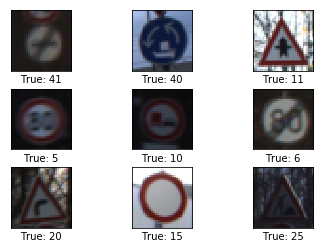

In [8]:
# Fetch 9 images from the test set, and the corresponding labels, such that they are approximately
# equidistant in the training set list
the_slice = slice(0, n_train, n_train // 8)
images = X_train[the_slice]
cls_true = y_train[the_slice]
# Plot the images with their labels (classes)
plot_images(images=images, cls_true=cls_true)

We display the frequency of each class in the training, validation and test dataset as a histogram. There is obviously disparity among classes, as per the number of pictures representing them. However, representation of each class is rather consistent across the three datasets.

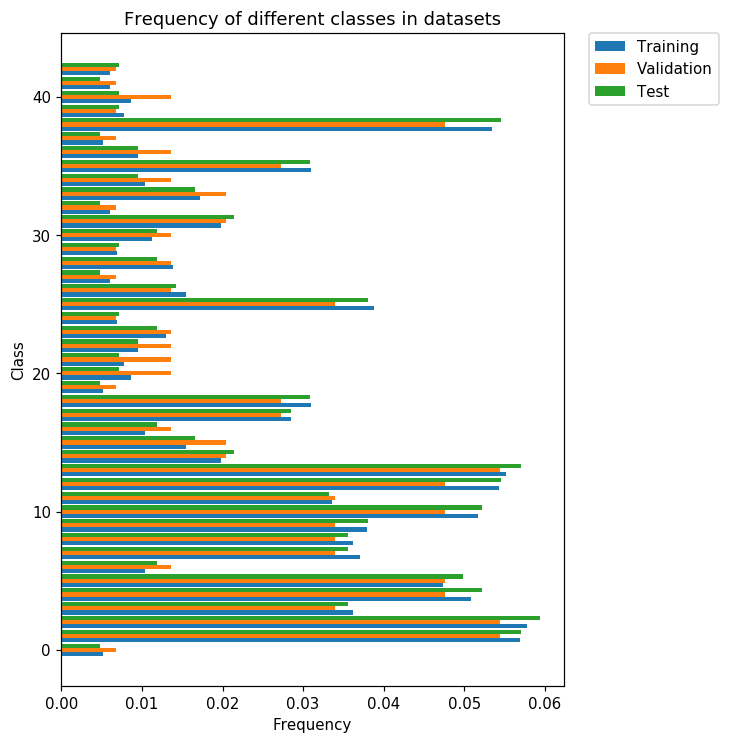

In [9]:
plot_labels_histogram([y_train, y_valid, y_test])

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set

Pre-processing performs the following steps:
 - Converts every image to YUV color space, then discard the U and V channels
 - Maps every pixel value from the [0, 255] interval to the [-1, 1] interval (of real numbers)
 - Calculates the average value of image pixels in the training set, and subtracts it from every pixel of every image in the training, validation, test and additional validation sets

In [10]:
# Pre-process the datasets
X_train, averages = pre_process_dataset(X_train)
'''Keep a copy of the original validation dataset images, to be able to display them at the end of the computation'''
X_valid_orig = copy.deepcopy(X_valid)
# Averages used to normalize the training set are used also for the validation and the test set, and the additional images
X_valid, _ = pre_process_dataset(X_valid, averages)
X_test, _ = pre_process_dataset(X_test, averages)
X_add_orig = copy.deepcopy(X_add)
X_add, _ = pre_process_dataset(X_add, averages)

### Model Architecture

Time to define the main optimization parameters. We will use the Adam algorithm as implemented by Tensorflow, with an exponentially decaying learning rate. We also build in the possibility to use L2 regularization, disabled by default (see variable `beta` here below).

In [11]:
# Instantiate the model
EPOCHS = 100
BATCH_SIZE = 256
initial_rate = 0.001
# Learning rate decay parameters
batches_per_epoch = ceil(len(X_train) / BATCH_SIZE)
decay_step = batches_per_epoch * 3
decay_rate = 0.95
'''Parameter for L2 regularization. Regularization cost is weighted by beta before being added to the overall loss.
Setting beta to 0 effectively disable regularization'''
beta = .0

# Placeholders for the input to the neural network
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, None)

# Builds the loss function, to be optimized
one_hot_y = tf.one_hot(y, n_classes)
logits, keep_prob, regularizers = build_network(x, n_classes)
softmax = tf.nn.softmax(logits)  # Useful to generate performance reports, below
prediction = tf.argmax(logits, 1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy + beta * regularizers)

# Define the learning rate
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(initial_rate,
                                           global_step=global_step,
                                           decay_steps=decay_step,
                                           decay_rate=decay_rate,
                                           staircase=True)

# Choose the optimization algorithm (Adam)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation, global_step=global_step)

# Evaluation of the model accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Will be used to save the computation status
saver = tf.train.Saver()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
def evaluate(X_data, y_data, batch_size, session=None):
    """
    Evaluates the model on the given dataset; returns the accuracy (real number in [0., 1.] interval) and a list
    with class predictions for elements in X_data.
    """
    num_examples = len(X_data)
    total_accuracy = 0
    predictions = []
    if session is None:
        session = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        accuracy, batch_prediction = sess.run([accuracy_operation, prediction], feed_dict={x: batch_x, y: batch_y})
        predictions.extend(list(batch_prediction))
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, predictions

A handy function to plot feature maps for convolutional layers (adapted from code provided by Udacity).

In [13]:
def output_activation_map(image_input, tf_activation, activation_min=-1, activation_max=-1, plt_num=64, session=tf.get_default_session()):
    """
    Plots the feature maps for a layer of the NN for a given input image
    :param image_input: the image to be fed to the NN, already pre-processed
    :param tf_activation: a Tensorflow variable containing the layer of interest
    :param activation_min: minimum value in an activation map, useful to enhance contrast
    :param activation_max: maximum value in an activation map, useful to enhance contrast
    :param plt_num: number of subplots to be plotted for multiple activation maps
    :param plt_num: the Tensorflow session, if None is provided, will use the default session
    """
    activation = tf_activation.eval(session=session, feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    fig, _ = plt.subplots()
    fig.set_dpi(108)
    fig.set_figheight(7)
    for featuremap in range(featuremaps):
        axes = plt.subplot(8, 8, featuremap + 1)  # sets the number of feature maps to show on each row and column
        axes.set_xticks([])
        axes.set_yticks([])
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmin=activation_min,
                       vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", cmap="gray")

Initialize the Tensorflow session.

In [14]:
sess= tf.Session(config=config)
sess.run(tf.global_variables_initializer())

For the image here below, we look at the activation map of the first convolutional layer, before training (weights are still initialized randomly). That is after the activation function but before max-pooling.

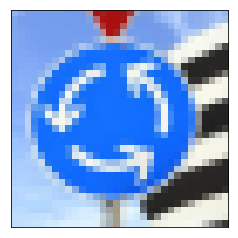

In [15]:
show_image(X_add_orig[3])

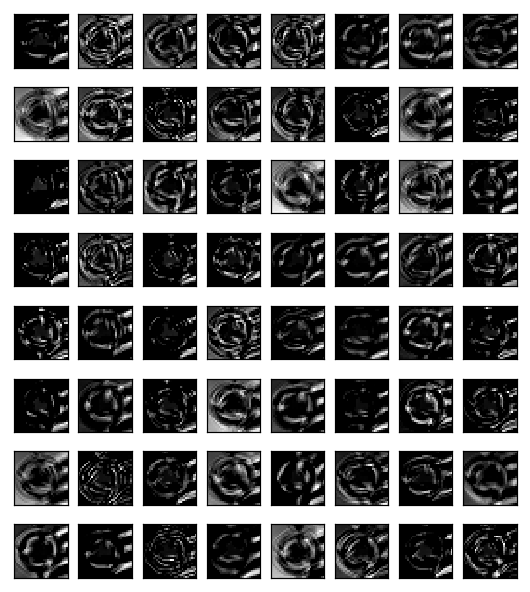

In [16]:
layer_to_show = sess.graph.get_tensor_by_name('activation1:0')
output_activation_map([X_add[3]], layer_to_show, session=sess)

About time to train the neural network, feeding the training dataset to the optimization algorithm in batches. During training, the program keeps track of an amount of information that will be used to display performances.

In [17]:
print("Training...\n")
# Initialize lists that will be used to plot accuracy and loss at every epoch
validation_accuracies, training_accuracies, losses = [], [], []
num_examples = len(X_train)
for i in range(EPOCHS):
    X_train, y_train = shuffle(X_train, y_train)
    # Run the optimization (training) on every training batch
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_train[offset:end], y_train[offset:end]
        _, loss, step = sess.run([training_operation, loss_operation, global_step],
                                feed_dict={x: batch_x, y: batch_y, keep_prob: .7})
    training_accuracy, _ = evaluate(X_train, y_train, BATCH_SIZE, session=sess)
    validation_accuracy, validation_prediction = evaluate(X_valid, y_valid, BATCH_SIZE)
    training_accuracies.append(training_accuracy)
    validation_accuracies.append(validation_accuracy)
    losses.append(loss)
    print("EPOCH {}/{};".format(i + 1, EPOCHS),
        "Learning rate {:.3e};".format(sess.run(learning_rate)),
        "Loss {:.3e};".format(loss),
        "Training acc. {:.3f};".format(training_accuracy),
        "Validation acc. {:.3f}".format(validation_accuracy))  

Training...

EPOCH 1/100; Learning rate 1.000e-03; Loss 5.740e-01; Training acc. 0.936; Validation acc. 0.894
EPOCH 2/100; Learning rate 1.000e-03; Loss 2.368e-01; Training acc. 0.981; Validation acc. 0.932
EPOCH 3/100; Learning rate 9.500e-04; Loss 1.221e-01; Training acc. 0.992; Validation acc. 0.961
EPOCH 4/100; Learning rate 9.500e-04; Loss 1.223e-01; Training acc. 0.995; Validation acc. 0.961
EPOCH 5/100; Learning rate 9.500e-04; Loss 1.536e-01; Training acc. 0.996; Validation acc. 0.962
EPOCH 6/100; Learning rate 9.025e-04; Loss 7.001e-02; Training acc. 0.998; Validation acc. 0.968
EPOCH 7/100; Learning rate 9.025e-04; Loss 5.763e-02; Training acc. 0.998; Validation acc. 0.969
EPOCH 8/100; Learning rate 9.025e-04; Loss 2.267e-02; Training acc. 0.999; Validation acc. 0.977
EPOCH 9/100; Learning rate 8.574e-04; Loss 4.775e-02; Training acc. 0.999; Validation acc. 0.969
EPOCH 10/100; Learning rate 8.574e-04; Loss 5.950e-02; Training acc. 0.999; Validation acc. 0.966
EPOCH 11/100; Le

In [18]:
# Save the status of the computation
saver.save(sess, 'session')
print("Trained model saved")
# Save the session graph (for TensorBoard)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('./graph', sess.graph)
print("Summary for TensorBoard saved")

Trained model saved
Summary for TensorBoard saved


Plot training and validation accuracy and loss recorded during the training process

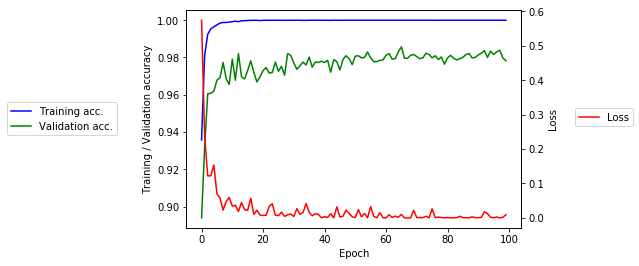

In [19]:
fig, ax = plt.subplots()
# ax.plot([training_accuracies, losses])
ax.plot(training_accuracies, color='blue', linestyle='-', label='Training acc.')
ax.plot(validation_accuracies, color='green', label='Validation acc.')
plt.legend(bbox_to_anchor=(-.55, .6), loc=2)
ax.set_ylabel('Training / Validation accuracy')
ax.set_xlabel('Epoch')
ax_alt = ax.twinx()
ax_alt.plot(losses, color='red', label='Loss')
ax_alt.set_ylabel('Loss')
plt.legend(bbox_to_anchor=(1.16, .55), loc=2, borderaxespad=0.)
pass  # Prevent printing of unwanted Matplotlib output in Jupyter Notebook

Let's look at some of the validation set images that have been mis-classified. We plot 9 of them, along with their correct class and the (incorrectly) predicted class. We also plot the softmax probability distribution of each.

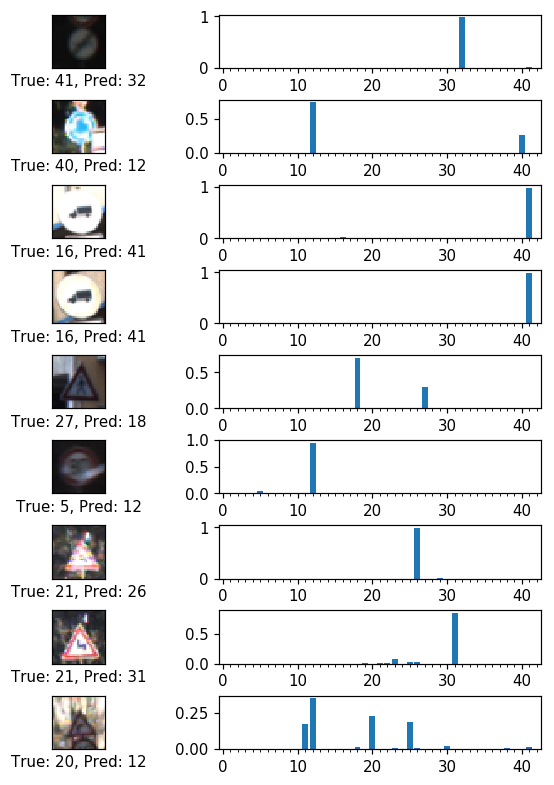

In [20]:
''' Fetch nine images from the validation set that have been mis-classified.They are choosen in such a way that they
are approximately equidistant within the list of all mis-classified validation images (it is more interesting
than showing the first nine!)'''
# Fill in an array of booleans where item i-th is True iff the i-th element in validation dataset as been correctly classified
predicted_right = validation_prediction == y_valid
# Count how many have been mis-classified in the validation set
n_misclassified = len(predicted_right) - predicted_right.sum()
interval = (n_misclassified - 1) // 8
n_found = 0
# Accumulate the 9 mis-classified images, their respective correct classification and classification by the NN
images, correct_labels, wrong_labels = [], [], []
for image, correct_label, is_correct, predicted in zip(X_valid_orig, y_valid, predicted_right,
                                                       validation_prediction):
    if not is_correct:
        n_found += 1
        if (n_found - 1) % interval == 0:
            images.append(image)
            correct_labels.append(correct_label)
            wrong_labels.append(predicted)

assert len(images) == len(correct_labels) == len(wrong_labels) <= 9

pre_processed, _ = pre_process_dataset(images, averages)
softmax_images = sess.run(softmax, feed_dict={x: pre_processed, y: correct_labels})
plot_probabilities(softmax_images, images, correct_labels, wrong_labels)

Let's now check performance of the trained network against the validation set on a per-class basis.

In [21]:
# Uncomment below to print the confusion matrix. It's rather large for a Jupyter Notebook.
'''
print('Confusion matrix:')
c_matrix = confusion_matrix(y_true=y_valid, y_pred=validation_prediction)
np.set_printoptions(threshold=c_matrix.shape[0] * c_matrix.shape[1] + 1,
    linewidth=(c_matrix.shape[1] + 2) * 4)
print(c_matrix)
'''
precision, recall, fscore, support = precision_recall_fscore_support(y_true=y_valid, y_pred=validation_prediction)

t = PrettyTable(['Class', 'Precision', 'Recall', 'F-score', 'Support'])
for item in zip(range(len(precision)), precision, recall, fscore, support):
    t.add_row(['{}'.format(item[0]),
               '{:.3f}'.format(item[1]),
               '{:.3f}'.format(item[2]),
               '{:.3f}'.format(item[3]),
               '{}'.format(item[4])])
print(t)

+-------+-----------+--------+---------+---------+
| Class | Precision | Recall | F-score | Support |
+-------+-----------+--------+---------+---------+
|   0   |   1.000   | 0.767  |  0.868  |    30   |
|   1   |   0.996   | 0.992  |  0.994  |   240   |
|   2   |   1.000   | 0.996  |  0.998  |   240   |
|   3   |   1.000   | 0.993  |  0.997  |   150   |
|   4   |   0.968   | 1.000  |  0.984  |   210   |
|   5   |   0.995   | 0.990  |  0.993  |   210   |
|   6   |   1.000   | 1.000  |  1.000  |    60   |
|   7   |   0.980   | 1.000  |  0.990  |   150   |
|   8   |   0.980   | 0.980  |  0.980  |   150   |
|   9   |   1.000   | 1.000  |  1.000  |   150   |
|   10  |   1.000   | 1.000  |  1.000  |   210   |
|   11  |   0.980   | 1.000  |  0.990  |   150   |
|   12  |   0.968   | 1.000  |  0.984  |   210   |
|   13  |   1.000   | 0.996  |  0.998  |   240   |
|   14  |   0.968   | 1.000  |  0.984  |    90   |
|   15  |   1.000   | 1.000  |  1.000  |    90   |
|   16  |   0.973   | 0.600  | 

Last but definitely not least, the model accuracy against the test dataset.

In [22]:
# Evaluate the model against the test set
test_accuracy, test_prediction = evaluate(X_test, y_test, BATCH_SIZE)
t = PrettyTable(['Model accuracy against the test set'])
t.add_row(['{:.3f}'.format(test_accuracy)])
print(t)

+-------------------------------------+
| Model accuracy against the test set |
+-------------------------------------+
|                0.971                |
+-------------------------------------+


---

## Step 3: Test a Model on New Images

I downloaded five pictures of German traffic signs from the web, and will use my model to predict the traffic sign type. Note: file `signnames.csv` contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images
The additional images have been already loaded and pre-processed above, see `X_add` (pre-processed), `y_add` (pre-processed) and `X_add_orig` (not pre-processed). Here they are.

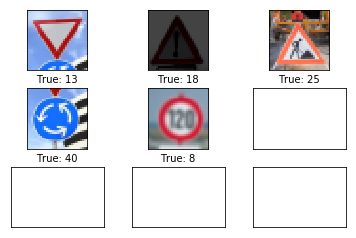

In [23]:
plot_images(X_add_orig, y_add)

### Predict the Sign Type for Each Image

In [24]:
top = tf.nn.top_k(softmax, k=5)
accuracy_add, top5_add, softmax_add, prediction_add = sess.run([accuracy_operation, top, softmax, prediction],
                                                feed_dict={x: X_add, y: y_add})                                 

### Analyze Performance

In [25]:
print('Accuracy on additional dataset is {:.3f}'.format(accuracy_add))

Accuracy on additional dataset is 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

The table has one row per image. Every row lists the five most probable classes predicted by the network, each with its probability.

In [26]:
headers = []
for i in range(1,6):
    headers.extend(['Pred'+str(i), 'Prob'+str(i)])
t = PrettyTable(headers)
for row_idx, row_prob in zip(top5_add[1], top5_add[0]):
    row = []
    for idx, prob in zip(row_idx, row_prob):
        row.extend(['{}'.format(idx),'{:.2e}'.format(prob)])
    t.add_row(row)
print(t)

+-------+----------+-------+----------+-------+----------+-------+----------+-------+----------+
| Pred1 |  Prob1   | Pred2 |  Prob2   | Pred3 |  Prob3   | Pred4 |  Prob4   | Pred5 |  Prob5   |
+-------+----------+-------+----------+-------+----------+-------+----------+-------+----------+
|   13  | 1.00e+00 |   3   | 2.25e-35 |   0   | 0.00e+00 |   1   | 0.00e+00 |   2   | 0.00e+00 |
|   18  | 1.00e+00 |   26  | 7.03e-11 |   27  | 9.13e-15 |   37  | 6.00e-17 |   24  | 8.79e-18 |
|   25  | 1.00e+00 |   20  | 4.32e-14 |   38  | 4.25e-14 |   23  | 5.07e-16 |   11  | 2.35e-16 |
|   40  | 1.00e+00 |   12  | 5.04e-07 |   11  | 2.80e-12 |   42  | 1.22e-12 |   16  | 8.28e-13 |
|   8   | 1.00e+00 |   7   | 4.64e-12 |   5   | 2.04e-14 |   0   | 1.11e-14 |   4   | 4.86e-15 |
+-------+----------+-------+----------+-------+----------+-------+----------+-------+----------+


We can look at the actual and predicted class of each additional image, along with its softmax probability distribution.

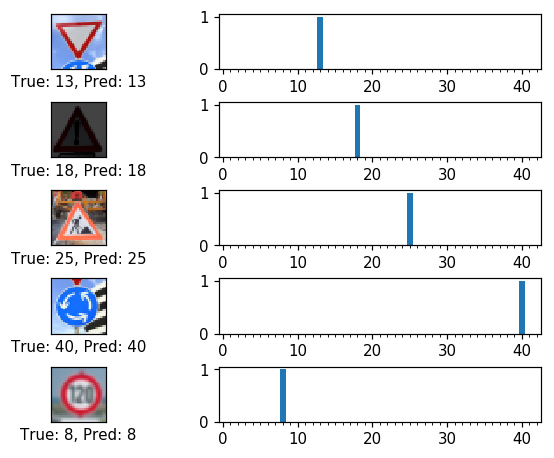

In [27]:
plot_probabilities(softmax_add, X_add_orig, y_add, prediction_add)

---

## Step 4: Visualize the Neural Network's State with Test Images


We plot the first activation layer again, for the same image as before, but after training of the network.

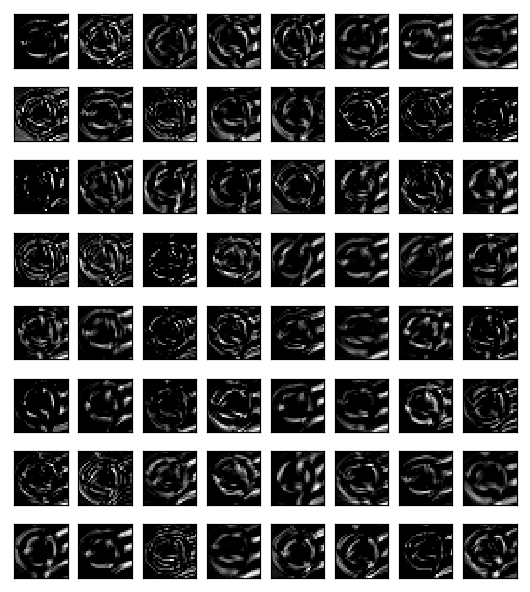

In [28]:
layer_to_show = sess.graph.get_tensor_by_name('activation1:0')
output_activation_map([X_add[3]], layer_to_show, plt_num=1, session=sess)

Here the corresponding feature map; again, after the first convolutional layer and activation function of the trained network. 

Close the Tensorflow session. Leave it commented out to make changes to the Notebook and run them right away.

In [29]:
# sess.close()

### Interpretation of the visual output of feature maps


We looked at feature maps coming out of the first convolutional layer, after the activation function but before the max-pool layer.

We checked the same feature map before and after training of the network, see cells [16] and [28]: in both cases, we can recognize features of the traffic sign in the input image. Does that give evidence that the network has learned to recognize those feature? Of course not, as in the first case, the activation map is plotted before the training, with weights randomly initialized!

However, we can notice that in the first activation map, before training, the sky in the image produces some activation (it is brighter in the map), while in the second activation map it doesn't (it is black). So ti looks like the network has "learned" to ignore the sky in the background for the purpose of classification.